In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-21 05:59:33.180843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 05:59:33.180879: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
import scanpy as sc

babel_dir = '../babel_data/DM_rep4/'
train = sc.read_h5ad(babel_dir + 'train_rna.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_rna.h5ad').X.toarray()
data1 = np.concatenate([train, valid], axis=0)
fnames1 = np.array(v)

train = sc.read_h5ad(babel_dir + 'train_atac.h5ad')
v = train.var_names
train = train.X.toarray()
valid = sc.read_h5ad(babel_dir + 'truth_atac.h5ad').X.toarray()
data2 = np.concatenate([train, valid], axis=0)
fnames2 = np.array(v)

split = train.shape[0]

/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/thema/miniconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [5]:
dataset_name = 'DM_rep4'
modality_names = ['RNA', 'ATAC']

# data1 = PCA(n_components=32).fit_transform(data1)
# data2 = PCA(n_components=32).fit_transform(data2)
# fnames1 = fnames2 = None

type1 = np.array(len(data1) * ['Cell Type 0'])
type2 = np.array(len(data2) * ['Cell Type 0'])

# Sampling
sample_num = split
# split = 500
data_col_idx = np.random.choice(range(split), sample_num, replace=False)
data1, data2, type1, type2 = (x[list(data_col_idx) + list(range(split, len(data1)))] for x in (data1, data2, type1, type2))
split = sample_num

# Labels
labels = [type1, type2]
features = [list(fnames1), list(fnames2)]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/thema/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. 

In [6]:
# Train-Test Imputation
train_idx = np.array(list(range(split)))
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [7]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 32
pca_dim = [256] * 2
dist_method = 'cosine'

# ComManDo

In [8]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': int(1e7),
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}

In [9]:
# Imputation
cm_im = ComManDo(**kwargs)
cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (3877, 34861)
Dataset 1: (3877, 85596)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:2.8908 alpha:0.7862
epoch:[1000/2000] err:0.0001 alpha:0.0000
epoch:[1500/2000] err:0.0000 alpha:0.0000
epoch:[2000/2000] err:0.0000 alpha:0.0000
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/10000000]: loss:1.573218
epoch:[1000/10000000]: loss:1.408750
epoch:[1500/10000000]: loss:1.378291
epoch:[2000/10000000]: loss:1.352528
epoch:[2500/10000000]: loss:1.331222
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 1198.4777745030005
Correspondence: 5028.577223907996
Mapping: 4547.837969763001
Total: 10774.892968173997



# Comparison Methods

In [10]:
# Imputation
if True:
    imputation_name = 'Babel'
    bdata1 = sc.read_h5ad(babel_dir + 'atac_rna_test_preds.h5ad').X.toarray()
    bdata2 = sc.read_h5ad(babel_dir + 'rna_atac_test_preds.h5ad').X.toarray()
    nn_imputed = [bdata1, bdata2]
else:
    imputation_name = 'NN'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]

# Visualization

In [11]:
# Samp, PCA
# RNA imp
# ATAC imp
# --
# 2000, 1024
# 3075, 3168
# 5117, 5212
# --
# 512, 512
# 2700, 2500
# --
# 1024, 512
# 2857, 2693
# 3496, 3582
# --
# 1024, 1024
# 2864, 2710
# 3454, 3540
# --
# 2048, 128
# 3148, 3178
# 4017, 4172
# --
# 2048, 2048
# 2902, 2713
# 3343, 3424
# --
# *, 256
# 3561, 3768
# 5680, 5790

In [12]:
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]
colors = ['blue', 'red', 'teal']
style='whitegrid'

sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

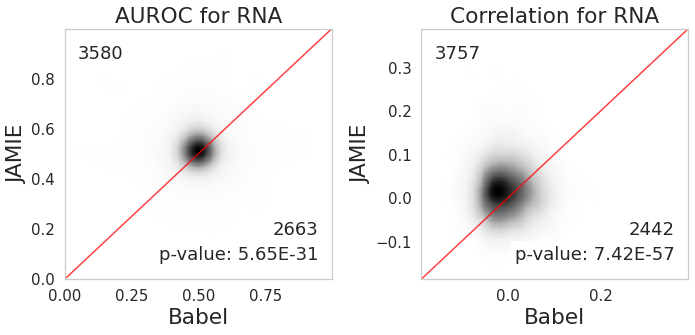

In [13]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png')

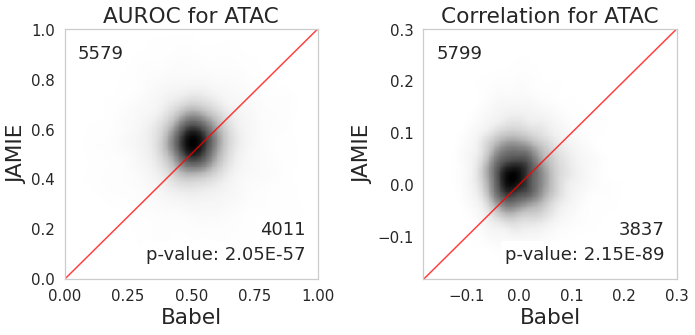

In [14]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png')

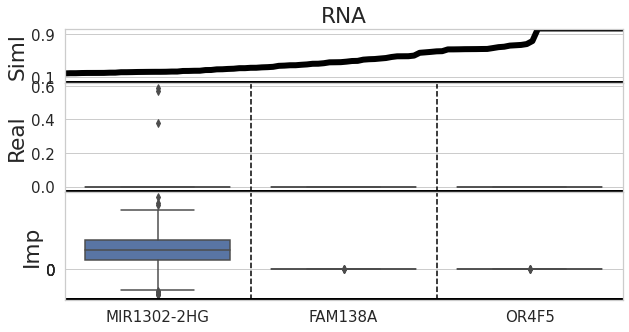

In [15]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png')

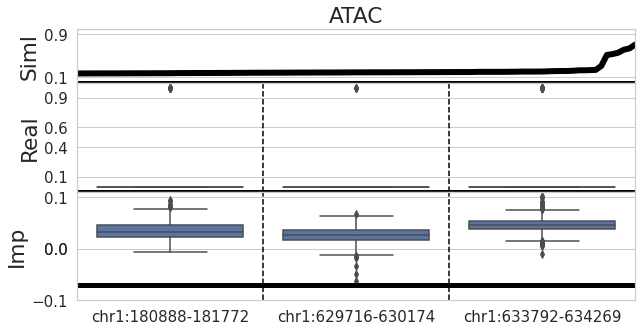

In [16]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png')

# Explanation

In [17]:
# RNA (Place) -> ATAC
# ATP13A3 (19) -> chr3:56205067-56205903

In [18]:
sns.set(style=style)

In [19]:
mod0, mod1 = 0, 1

In [24]:
dist_sort = np.argsort(np.abs(cm_imputed[mod1] - dataset[mod1][test_idx]).sum(0))
from scipy.stats import pearsonr
corr_arr = np.array([pearsonr(cm_imputed[mod1][:, i], dataset[mod1][test_idx, i])[0] for i in range(dataset[mod1].shape[1])])
corr_sort = np.argsort(corr_arr)[::-1]
temp_order = np.argsort(np.array([np.argwhere(dist_sort==i)[0][0] + np.argwhere(corr_sort==i)[0][0] for i in range(dataset[mod1].shape[1])]))
thresh1, thresh2 = dataset[mod1].mean(0) > 0, np.std(dataset[mod1], 0) > np.percentile(np.std(dataset[mod1], 0), 99.5)
order = [i for i in temp_order if thresh1[i] and thresh2[i]]
order_str = ', '.join([str(n) for n in order[:10]])
print(f'Top candidate features for SHAP: {order_str}')

Top candidate features for SHAP: 53302, 54799, 36076, 84205, 20005, 31397, 40734, 31398, 6842, 31617


In [ ]:
import shap

# Subset for runtime
use_subsetting = True
subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
def take_subset(x, do=use_subsetting):
    if not do:
        return x
    if len(x.shape) == 1:
        return x[subset_idx]
    return x[:, subset_idx]
def reverse_subset(x, do=use_subsetting):
    if not do:
        return x
    new_vec = np.concatenate(x.shape[0] * [background], axis=0)
    new_vec[:, subset_idx] = x
    return new_vec

target_feature = order[0]
current_cm = cm_im
model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
data = dataset[mod0]
back = background
feature_names = features[mod0]
output_names = features[mod1][target_feature]

# Apply subsetting
data = take_subset(data)
back = take_subset(back)
feature_names = list(take_subset(np.array(feature_names)))

# Explainer
explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
shap_values = explainer(data, max_evals=2*data.shape[1]+1)

In [61]:
print(f'Target {modality_names[mod1]} Feature: {output_names}')
for n in [output_names]:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:20]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n in importance:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target ATAC Feature: chr3:56205067-56205903
https://www.genecards.org/cgi-bin/carddisp.pl?gene=chr3:56205067-56205903
Important RNA Features: L2HGDH, MED13, SYNPO2, FBXL12, RPUSD2, OXR1, MMP16, AC099850.1, LIN7B, UCK2, WDR7, FKBP10, TRERF1, PLEKHA3, FN3KRP, CDC42SE1, AURKB, RECQL, ATP13A3, RAB2A
https://www.genecards.org/cgi-bin/carddisp.pl?gene=L2HGDH
https://www.genecards.org/cgi-bin/carddisp.pl?gene=MED13
https://www.genecards.org/cgi-bin/carddisp.pl?gene=SYNPO2
https://www.genecards.org/cgi-bin/carddisp.pl?gene=FBXL12
https://www.genecards.org/cgi-bin/carddisp.pl?gene=RPUSD2
https://www.genecards.org/cgi-bin/carddisp.pl?gene=OXR1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=MMP16
https://www.genecards.org/cgi-bin/carddisp.pl?gene=AC099850.1
https://www.genecards.org/cgi-bin/carddisp.pl?gene=LIN7B
https://www.genecards.org/cgi-bin/carddisp.pl?gene=UCK2
https://www.genecards.org/cgi-bin/carddisp.pl?gene=WDR7
https://www.genecards.org/cgi-bin/carddisp.pl?gene=FKBP10
https://www.

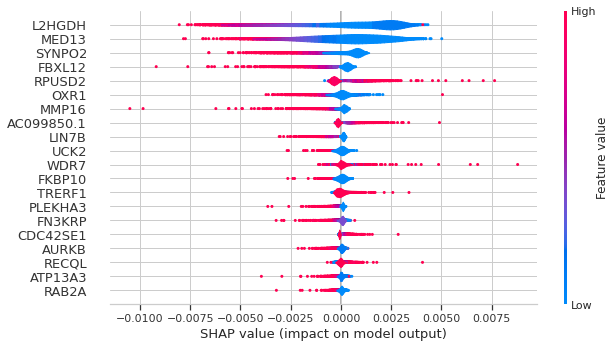

In [62]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=20, plot_size=(9.2, 5), show=False)
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

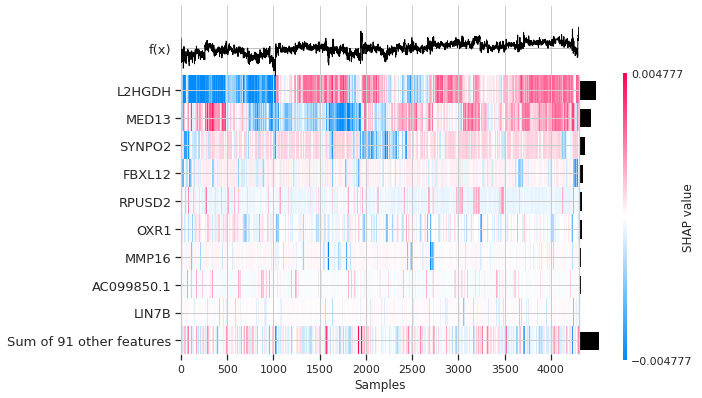

In [63]:
shap.plots.heatmap(shap_values, show=False)
plt.gca().set_xlabel('Samples')
plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

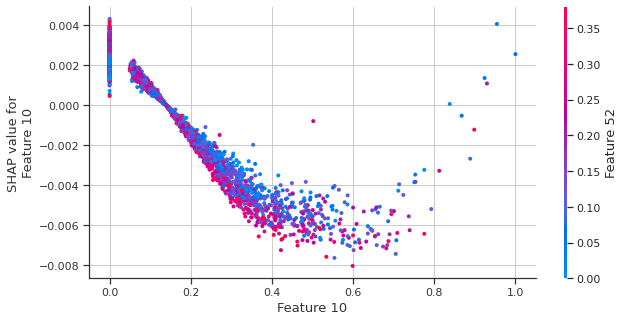

In [64]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

## Interactive

In [ ]:
# Kernel Explainer
kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    kshap_values = kexplainer.shap_values(data, nsamples=100)

In [ ]:
shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [ ]:
shap.initjs()
shap.force_plot(kexplainer.expected_value, kshap_values, data)